In [1]:
using CSV
using DataFrames
using PyPlot
using Printf
using Juliana
using ProgressBars
using Statistics
using StatsPlots

In [2]:
function conformity_index(dose_distribution,
                          target::Juliana.Structure,
                          target_dose::Real)
    return sum(dose_distribution .>= 0.95 * target_dose) / sum(target.mask)
end

conformity_index (generic function with 1 method)

# Config

In [3]:
data_dir = "/data/user/bellotti_r/data"
work_dir = "./output"
series_ID = 0;

# Load data

In [4]:
patients = Dict{String, Juliana.PatientData}()
reference_doses = Dict{String, Array}()
auto_doses = Dict{String, Array}()

for i in ProgressBar(0:18)
    patient_ID = @sprintf("test_%02d", i)
    
    ct_path, patient = Juliana.load_patient_data(data_dir, patient_ID);
    
    target_name, target_dose = Juliana.hottest_target(patient.prescriptions)
    normalisation_mask = convert.(Float32, collect(Juliana.calculate_normalisation_mask(
        patient.prescriptions,
        patient.structures,
    )));
    
    reference_dose = Juliana.load_dose_dat_file("$data_dir/clinical_dose_distributions/$(patient_ID)_$(series_ID).dat").data
    reference_dose = Juliana.normalise_dose(reference_dose, normalisation_mask, target_dose)

    auto_dose = Juliana.load_dose_dat_file("$(work_dir)/$(patient_ID)/result_dose.dat").data
    auto_dose = Juliana.normalise_dose(auto_dose, normalisation_mask, target_dose);
    
    patients[patient_ID] = patient
    reference_doses[patient_ID] = reference_dose
    auto_doses[patient_ID] = auto_dose
end

0.0%┣                                               ┫ 0/19 [00:00<00:-1, -0s/it]
5.3%┣██▎                                        ┫ 1/19 [00:20<Inf:Inf, InfGs/it]
10.5%┣████▉                                         ┫ 2/19 [00:25<07:01, 25s/it]
┌ Warning: Could not find a structure named unknown
└ @ Juliana /data/user/bellotti_r/differentiable_planning_reproduction/src/DataLoading.jl:184
15.8%┣███████▎                                      ┫ 3/19 [00:28<03:44, 14s/it]
┌ Warning: Could not find a structure named unknown
└ @ Juliana /data/user/bellotti_r/differentiable_planning_reproduction/src/DataLoading.jl:184
┌ Warning: Could not find a structure named unknown
└ @ Juliana /data/user/bellotti_r/differentiable_planning_reproduction/src/DataLoading.jl:184
21.1%┣█████████▊                                    ┫ 4/19 [00:34<02:48, 11s/it]
26.3%┣████████████▍                                  ┫ 5/19 [00:38<02:12, 9s/it]
31.6%┣██████████████▉                                ┫ 6/19 [00:42<01:50, 8s

In [5]:
patient_IDs = sort(collect(keys(patients)))

19-element Vector{String}:
 "test_00"
 "test_01"
 "test_02"
 "test_03"
 "test_04"
 "test_05"
 "test_06"
 "test_07"
 "test_08"
 "test_09"
 "test_10"
 "test_11"
 "test_12"
 "test_13"
 "test_14"
 "test_15"
 "test_16"
 "test_17"
 "test_18"

# Calculate metrics

In [6]:
metrics = Array{Dict}(undef, 0)

for patient_ID in ProgressBar(patient_IDs)
    patient = patients[patient_ID]
    reference_dose = reference_doses[patient_ID]
    auto_dose = auto_doses[patient_ID]
    
    coldest_target_name, coldest_target_dose = Juliana.coldest_target(patient.prescriptions)
    hottest_target_name, target_dose = Juliana.hottest_target(patient.prescriptions)
    target_mask = patient.structures[hottest_target_name].mask

    V95_reference = Juliana.dvh_v(reference_dose, target_mask, 0.95 * target_dose)
    V95_auto = Juliana.dvh_v(auto_dose, target_mask, 0.95 * target_dose);

    D95_reference = Juliana.dvh_d(reference_dose, collect(target_mask), 5f0)
    D5_reference = Juliana.dvh_d(reference_dose, collect(target_mask), 95f0)
    HI_reference = (D5_reference - D95_reference)
    CI_reference = conformity_index(
        reference_dose,
        patient.structures[coldest_target_name],
        coldest_target_dose,
    )

    D95_auto = Juliana.dvh_d(auto_dose, collect(target_mask), 5f0)
    D5_auto = Juliana.dvh_d(auto_dose, collect(target_mask), 95f0)
    HI_auto = (D5_auto - D95_auto)
    CI_auto = conformity_index(
        auto_dose,
        patient.structures[coldest_target_name],
        coldest_target_dose,
    )

    Dmax_reference = maximum(reference_dose)
    Dmax_auto = maximum(auto_dose)

    metrics_reference = Dict(
        "patient_ID" => patient_ID,
        "HI" => HI_reference,
        "V95" => V95_reference,
        "CI" => CI_reference,
        "Dmin_target" => minimum(reference_dose[target_mask]) * 100 / target_dose,
        "Dmax" => Dmax_reference * 100 / target_dose,
        "method" => "reference",
    )
    metrics_auto = Dict(
        "patient_ID" => patient_ID,
        "HI" => HI_auto,
        "V95" => V95_auto,
        "CI" => CI_auto,
        "Dmin_target" => minimum(auto_dose[target_mask]) * 100 / target_dose,
        "Dmax" => Dmax_auto * 100 / target_dose,
        "method" => "auto",
    )

    push!(metrics, metrics_reference)
    push!(metrics, metrics_auto)
    
    df = DataFrame([metrics_reference, metrics_auto])
    CSV.write("metrics_$(patient_ID).csv", df)
end

0.0%┣                                               ┫ 0/19 [00:00<00:-1, -0s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[51.780598, 57.946724, 59.878284, 60.844063, 61.95842, 62.701332, 63.369946, 63.88998, 64.63289, 65.15292, 65.45008, 65.82154, 66.1187, 66.41586, 66.63873, 66.8616, 67.15877, 67.30735, 67.53023, 67.6788, 67.90168, 68.12454, 68.34742, 68.496, 68.644585, 68.867455, 69.01604, 69.16462, 69.3132, 69.461784, 69.61037, 69.684654, 69.83323, 69.907524, 70.05611, 70.20469, 70.27898, 70.42756, 70.50185, 70.65043, 70.72472, 70.87331, 70.94759, 71.02188, 71.096176, 71.17046, 71.319046, 71.39333, 71.46762, 71.54192, 71.61621, 71.6905, 71.6905, 71.76479, 71.83908, 71.913376, 71.98767, 72.06196, 72.06196, 72.13624, 72.210526, 72.210526, 72.28483, 72.359116, 72.359116, 72.4334, 72.4334, 72.5077, 72.5077, 72.581985, 72.581985, 72.65628, 72.65628, 72.730576, 72.730576, 72.730576, 72.80

10.5%┣█████                                          ┫ 2/19 [00:05<01:20, 5s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[15.990683, 16.643362, 17.296045, 17.500006, 17.601988, 17.70397, 17.785553, 17.826347, 17.846743, 17.907934, 17.948725, 17.96912, 18.009912, 18.03031, 18.071102, 18.091497, 18.111895, 18.132292, 18.152687, 18.173082, 18.213877, 18.234272, 18.25467, 18.275064, 18.275064, 18.29546, 18.315857, 18.336254, 18.336254, 18.35665, 18.377045, 18.397442, 18.417841, 18.417841, 18.438236, 18.45863, 18.479027, 18.499424, 18.519823, 18.540216, 18.560614, 18.58101, 18.601404, 18.621801, 18.642199, 18.662596, 18.682991, 18.682991, 18.703386, 18.723783, 18.74418, 18.74418, 18.764576, 18.764576, 18.784971, 18.784971, 18.805368, 18.805368, 18.825766, 18.825766, 18.84616, 18.84616, 18.866556, 18.866556, 18.866556, 18.886953, 18.886953, 18.907349, 18.927748, 18.927748, 18.948143, 18.9481

21.1%┣██████████                                     ┫ 4/19 [00:05<00:26, 2s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[49.81149, 50.29147, 50.55813, 50.71812, 50.878113, 50.984776, 51.14477, 51.25143, 51.304764, 51.411427, 51.51809, 51.571423, 51.624756, 51.67809, 51.73142, 51.73142, 51.784748, 51.784748, 51.838074, 51.838074, 51.891415, 51.944744, 51.944744, 51.998074, 52.051407, 52.051407, 52.104736, 52.104736, 52.104736, 52.158073, 52.158073, 52.2114, 52.2114, 52.264732, 52.264732, 52.31806, 52.31806, 52.31806, 52.37139, 52.37139, 52.424725, 52.424725, 52.424725, 52.478058, 52.478058, 52.53139, 52.53139, 52.53139, 52.53139, 52.53139, 52.584717, 52.584717, 52.584717, 52.584717, 52.63805, 52.63805, 52.63805, 52.63805, 52.691383, 52.691383, 52.744713, 52.744713, 52.744713, 52.744713, 52.744713, 52.798042, 52.798042, 52.798042, 52.851376, 52.851376, 52.851376, 52.851376, 52.851376, 5

31.6%┣██████████████▉                                ┫ 6/19 [00:06<00:15, 1s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[46.50596, 47.404366, 47.879997, 48.249935, 48.51417, 48.72556, 48.8841, 49.04265, 49.148342, 49.148342, 49.254036, 49.30689, 49.359737, 49.41258, 49.518276, 49.571125, 49.67682, 49.782513, 49.782513, 49.835365, 49.88821, 49.941055, 49.993904, 50.046753, 50.099606, 50.152447, 50.205296, 50.258144, 50.258144, 50.31099, 50.31099, 50.36384, 50.36384, 50.416687, 50.469536, 50.469536, 50.52238, 50.52238, 50.57523, 50.57523, 50.62808, 50.680923, 50.680923, 50.680923, 50.733772, 50.733772, 50.78662, 50.78662, 50.78662, 50.83947, 50.89232, 50.89232, 50.945164, 50.945164, 50.998013, 50.998013, 51.050858, 51.050858, 51.050858, 51.103703, 51.103703, 51.156555, 51.156555, 51.156555, 51.209404, 51.209404, 51.262253, 51.262253, 51.315098, 51.315098, 51.367943, 51.367943, 51.420795

42.1%┣███████████████████▉                           ┫ 8/19 [00:08<00:12, 1s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[46.897366, 51.88773, 52.66935, 53.090225, 53.511097, 53.81172, 54.112347, 54.29273, 54.473095, 54.653473, 54.833843, 54.954098, 55.074345, 55.1946, 55.314846, 55.435093, 55.555344, 55.675594, 55.735718, 55.85597, 55.916092, 56.036343, 56.09647, 56.156593, 56.27684, 56.336964, 56.39709, 56.45722, 56.51734, 56.577465, 56.63759, 56.697716, 56.75784, 56.817963, 56.87809, 56.938213, 56.99834, 57.058464, 57.118587, 57.118587, 57.17871, 57.238834, 57.298965, 57.35909, 57.35909, 57.419212, 57.419212, 57.479336, 57.53946, 57.53946, 57.599586, 57.65971, 57.65971, 57.719837, 57.719837, 57.77996, 57.840084, 57.840084, 57.900215, 57.900215, 57.900215, 57.960335, 57.960335, 58.02046, 58.02046, 58.08058, 58.08058, 58.14071, 58.14071, 58.14071, 58.20084, 58.20084, 58.20084, 58.2609

52.6%┣████████████████████████▏                     ┫ 10/19 [00:11<00:11, 1s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[15.52737, 22.254292, 22.447178, 22.567732, 22.640064, 22.712397, 22.760618, 22.784729, 22.832949, 22.857063, 22.881174, 22.929394, 22.953505, 22.977615, 22.977615, 23.001726, 23.025837, 23.049948, 23.074059, 23.098171, 23.098171, 23.12228, 23.14639, 23.14639, 23.170502, 23.194613, 23.194613, 23.218725, 23.242834, 23.242834, 23.266945, 23.266945, 23.291054, 23.291054, 23.315166, 23.315166, 23.339281, 23.36339, 23.36339, 23.3875, 23.3875, 23.41161, 23.41161, 23.43572, 23.43572, 23.459833, 23.459833, 23.483944, 23.483944, 23.483944, 23.508055, 23.508055, 23.532166, 23.532166, 23.556276, 23.556276, 23.580387, 23.580387, 23.604498, 23.604498, 23.604498, 23.628609, 23.628609, 23.65272, 23.65272, 23.65272, 23.67683, 23.67683, 23.67683, 23.700941, 23.700941, 23.700941, 23.7

63.2%┣█████████████████████████████                 ┫ 12/19 [00:13<00:08, 1s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[35.59844, 36.90687, 38.17019, 38.892082, 39.343266, 39.83957, 40.516346, 40.87729, 41.057766, 41.32848, 41.508953, 41.689426, 41.82478, 41.960133, 42.05037, 42.140606, 42.275963, 42.366203, 42.45644, 42.501556, 42.591793, 42.636913, 42.68203, 42.727146, 42.772266, 42.817387, 42.862503, 42.90762, 42.90762, 42.95274, 42.99786, 43.042976, 43.088093, 43.088093, 43.133213, 43.223454, 43.223454, 43.26857, 43.31369, 43.358807, 43.358807, 43.403923, 43.449047, 43.494164, 43.494164, 43.53928, 43.584396, 43.584396, 43.629517, 43.629517, 43.674637, 43.719757, 43.719757, 43.719757, 43.764874, 43.764874, 43.80999, 43.80999, 43.855106, 43.855106, 43.90023, 43.90023, 43.945347, 43.945347, 43.945347, 43.990463, 43.990463, 44.035583, 44.0807, 44.0807, 44.12582, 44.12582, 44.170937, 

73.7%┣██████████████████████████████████            ┫ 14/19 [00:15<00:06, 1s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[43.67929, 44.906807, 45.418278, 45.725155, 45.87859, 46.134327, 46.338913, 46.492355, 46.543503, 46.645794, 46.696945, 46.74809, 46.850384, 46.901527, 46.95268, 47.003826, 47.054974, 47.15726, 47.208412, 47.310703, 47.413, 47.464146, 47.464146, 47.51529, 47.51529, 47.566437, 47.566437, 47.617584, 47.617584, 47.66873, 47.66873, 47.66873, 47.66873, 47.719875, 47.719875, 47.719875, 47.771023, 47.771023, 47.82217, 47.82217, 47.873318, 47.873318, 47.92446, 47.92446, 47.975613, 47.975613, 47.975613, 48.02676, 48.02676, 48.02676, 48.0779, 48.0779, 48.129047, 48.129047, 48.180195, 48.180195, 48.231346, 48.28249, 48.28249, 48.28249, 48.333637, 48.384785, 48.384785, 48.384785, 48.43593, 48.43593, 48.43593, 48.43593, 48.487076, 48.538223, 48.538223, 48.538223, 48.538223, 48.58

84.2%┣██████████████████████████████████████▊       ┫ 16/19 [00:16<00:03, 1s/it]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[44.88698, 50.018612, 50.549465, 51.670166, 52.37798, 53.203754, 53.43969, 53.852585, 54.619377, 55.03227, 55.327187, 55.445156, 55.56312, 55.740074, 56.034996, 56.447884, 56.683823, 56.801796, 56.860775, 56.919758, 56.97874, 57.037727, 57.037727, 57.096718, 57.096718, 57.1557, 57.1557, 57.214684, 57.214684, 57.273663, 57.273663, 57.273663, 57.273663, 57.332645, 57.332645, 57.332645, 57.391636, 57.391636, 57.45062, 57.45062, 57.45062, 57.45062, 57.45062, 57.509605, 57.56859, 57.56859, 57.56859, 57.56859, 57.62757, 57.62757, 57.62757, 57.686558, 57.686558, 57.686558, 57.686558, 57.686558, 57.74554, 57.74554, 57.74554, 57.74554, 57.804523, 57.804523, 57.804523, 57.804523, 57.863506, 57.863506, 57.863506, 57.863506, 57.863506, 57.922493, 57.922493, 57.922493, 57.922493,

94.7%┣███████████████████████████████████████████▋  ┫ 18/19 [00:16<00:01, 1it/s]
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[47.89722, 49.499317, 49.941277, 50.16226, 50.383232, 50.49373, 50.604214, 50.714706, 50.76995, 50.88044, 50.93568, 50.99093, 51.101418, 51.101418, 51.211906, 51.211906, 51.267155, 51.322395, 51.322395, 51.37764, 51.432884, 51.48813, 51.543373, 51.543373, 51.59862, 51.653866, 51.709106, 51.764355, 51.764355, 51.8196, 51.874844, 51.874844, 51.930088, 51.985332, 51.985332, 52.040577, 52.040577, 52.095825, 52.095825, 52.15107, 52.15107, 52.15107, 52.20631, 52.261555, 52.261555, 52.261555, 52.3168, 52.3168, 52.372047, 52.372047, 52.427288, 52.427288, 52.482536, 52.482536, 52.53778, 52.53778, 52.59302, 52.59302, 52.648273, 52.648273, 52.703514, 52.703514, 52.703514, 52.75876, 52.75876, 52.814003, 52.814003, 52.869247, 52.869247, 52.92449, 52.92449, 52.979736, 52.979736, 5

In [7]:
metrics = DataFrame(metrics)
metrics = metrics[:, [
    "patient_ID",
    "method",
    "Dmin_target",
    "V95",
    "Dmax",
    "HI",
    "CI",
        
]]

CSV.write("metrics.csv", metrics)

"metrics.csv"

# Plot

In [8]:
reference_metrics = metrics[metrics[!, "method"] .== "reference", :]
auto_metrics = metrics[metrics[!, "method"] .== "auto", :]

difference = reference_metrics[!, Not(["patient_ID", "method"])] .- auto_metrics[!, Not(["patient_ID", "method"])];

In [9]:
default_colors = PyPlot.matplotlib.rcParams["axes.prop_cycle"].by_key()["color"];

In [10]:
difference[:, Not("CI")]

,Dmin_target,V95,Dmax,HI
,Float32,Float64,Float32,Float32
1,1.22187,-3.88536,0.25708,2.92203
2,15.3674,2.67961,0.636711,-0.838409
3,14.2162,-2.46556,4.91368,-0.512518
4,-3.13837,2.14288,1.64012,-0.570522
5,9.6703,1.60797,1.38023,0.184708
6,8.59077,0.879408,2.67488,-1.33064
7,23.3237,7.80367,-0.998085,-3.10702
8,12.3991,-3.3459,4.6399,2.63383
9,12.8253,-2.75846,4.03165,1.84321


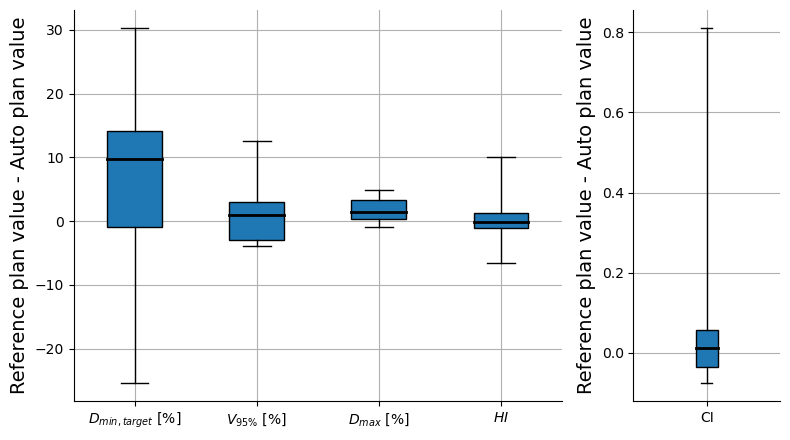

In [11]:
fig, axes = subplots(1, 2, figsize=(8, 4.5), gridspec_kw=Dict("width_ratios" => [1, 0.3]),)

ax = axes[1]
bp = ax.boxplot(Array(difference[:, Not("CI")]), whis=100000, patch_artist=true)

for i in 1:size(difference, 2)-1
    med = bp["medians"][i]
    med.set_color("black")
    med.set_linewidth(2)
    
    box = bp["boxes"][i]
    box.set_edgecolor("black")
    box.set_facecolor(default_colors[1])
end

ax.set_xticklabels(replace(
    names(difference[:, Not("CI")]),
    "Dmax" => L"$D_{max}$ [%]",
    "Dmin_target" => L"$D_{min, target}$ [%]",
    "HI" => L"$HI$",
#     "CI" => L"$CI$",
    "V95" => L"$V_{95\%}$ [%]",
))


ax = axes[2]
bp = ax.boxplot(Array(difference.CI), whis=100000, patch_artist=true)

med = bp["medians"][1]
med.set_color("black")
med.set_linewidth(2)

box = bp["boxes"][1]
box.set_edgecolor("black")
box.set_facecolor(default_colors[1])

ax.set_xticklabels(["CI"])



for ax in axes
    ax.grid(true)
    ax.set_ylabel("Reference plan value - Auto plan value", fontsize=14)

    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end


fig.tight_layout()
fig.savefig("dose_metrics_boxplot.jpg", dpi=300);

# Analyse

In [12]:
long_difference = stack(difference);

In [13]:
statistics = combine(
    groupby(long_difference, :variable),
    "value" => minimum => "min",
    "value" => (x -> quantile(x, 0.25)) => "25%",
    "value" => median => "50%",
    "value" => (x -> quantile(x, 0.75)) => "75%",
    "value" => maximum => "max",
    "value" => mean => "mean",
    "value" => std => "std",
)

metric_cols = ["min", "25%", "50%", "75%", "max", "mean", "std"]

statistics[:, metric_cols] .= round.(statistics[:, metric_cols], digits=1)
statistics

,variable,min,25%,50%,75%,max,mean,std
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Dmin_target,-25.4,-1.0,9.7,14.2,30.3,6.2,14.6
2,V95,-3.9,-3.0,0.9,3.0,12.5,1.0,4.6
3,Dmax,-1.0,0.4,1.4,3.3,4.9,1.7,1.9
4,HI,-6.5,-1.0,-0.1,1.3,10.1,0.1,3.4
5,CI,-0.1,-0.0,0.0,0.1,0.8,0.1,0.2
